In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import json

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

import torch
from torch import nn
import torch_geometric.nn as gnn
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.data import Data

import umap
from umap.umap_ import nearest_neighbors
# from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
import random

from joblib import Parallel, delayed

from model.model import *
import model.utilities as utils
from model.slide_utilities import *

import warnings
warnings.filterwarnings('ignore')

device = "cuda"
torch.set_num_threads(100)

seed = 100
torch.manual_seed(seed)

data_dir = "/epyc/robin/xenium_outs/"

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def bound_check(x, x0, x1):
    if x0 == None:
        result = (x < x1)
    elif x1 == None:
        result = (x > x0)
    else:
        result = (x > x0) and (x < x1)
    return result

xy_check = lambda x, y : (bound_check(x, x0, x1) and bound_check(y, y0, y1))

with open("annotations/slides_patients_annotation.json", 'r') as file:
    slide_info = json.load(file)

In [3]:
slide_info['slide2file']

{'1': 'output-XETG00088__0011762__Region_1__20240124__111313.h5ad',
 '2': 'output-XETG00088__0011186__Region_1__20240124__111313.h5ad',
 '3': 'output-XETG00088__0011546__Region_1__20240130__161548.h5ad',
 '4': 'output-XETG00088__0011216__Region_1__20240130__161548.h5ad',
 '5': 'output-XETG00088__0011707__Region_1__20240202__104242.h5ad',
 '6': 'output-XETG00088__0011695__Region_1__20240202__104242.h5ad',
 '7': 'output-XETG00088__0011284__Region_1__20240206__171802.h5ad',
 '8': 'output-XETG00088__0011287__Region_1__20240206__171802.h5ad'}

In [4]:
# Read Xenium Kidney Data
slide = '8'
slide2file = slide_info['slide2file']
adata = sc.read_h5ad(filename = data_dir + slide2file[slide])
print(f'Selected slide: {slide}')
print('Samples:')
slide_info['sample_info'][f'slide_{slide}']['label']

Selected slide: 8
Samples:


{'x49': 'anca',
 'x50': 'anca',
 'x51': 'anca',
 'x52': 'anca',
 'x53': 'anca',
 'x54': 'sle',
 'x55': 'sle',
 'x56': 'sle'}

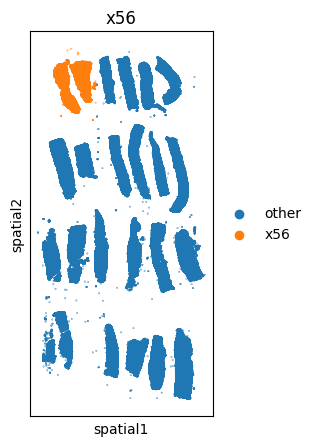

In [5]:
sample = 'x56'
bounds_dict = slide_info['sample_info']
x0, x1, y0, y1  = bounds_dict[f'slide_{slide}']['bounds'][sample]

sample_bin = [sample if xy_check(x, y) else 'other' for x,y in zip(adata.obs['x_centroid'], adata.obs['y_centroid'])]
adata.obs[sample] = sample_bin

fig, ax = plt.subplots(figsize=(5, 5)) 
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        sample,
    ],
    wspace=0.1,
    size=0.1,
    ax=ax
)
adata.uns.pop(f'{sample}_colors');

In [6]:
print(adata.shape)
adata = adata[adata.obs[sample] == sample]
print(adata.shape)

(573764, 480)
(47597, 480)


In [7]:
# Preprocessing
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

<Axes: title={'center': 'Area of segmented cells'}, xlabel='cell_area', ylabel='Count'>

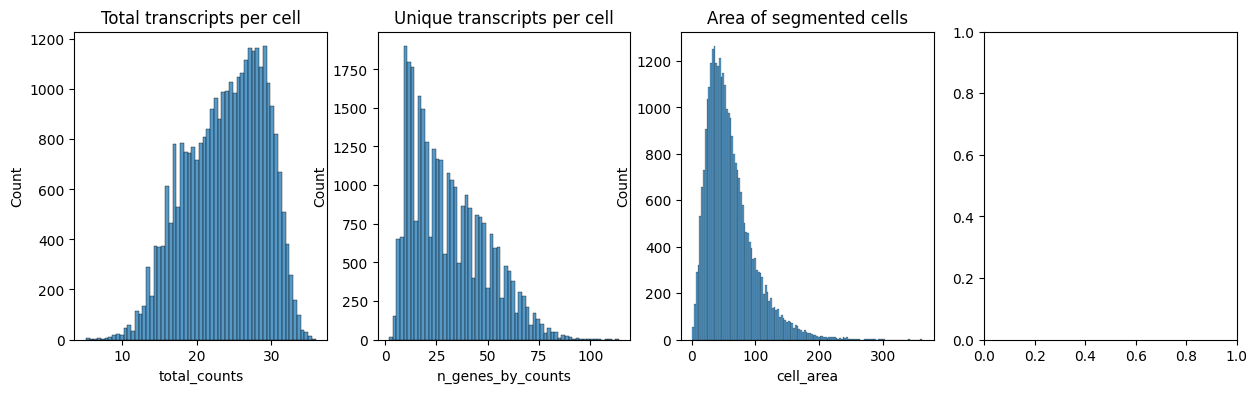

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

In [9]:
adata.X.max()

3.7826734

In [10]:
# Make the spatial network for Morans'I
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep="spatial", key_added = "spatial", knn=True, n_neighbors=4) 
m = sc.metrics.morans_i(adata.obsp["spatial_connectivities"], adata.obsm["X_pca"].T).mean()
g = sc.metrics.gearys_c(adata.obsp["spatial_connectivities"], adata.obsm["X_pca"].T).mean()
print(f"morans_i with PCA = {m}")
print(f"gearys_c with PCA = {g}")

morans_i with PCA = 0.171254229444223
gearys_c with PCA = 0.833154990194876


In [11]:
# Convert X and centers as torch.tensor
X = adata.X.toarray()
X = torch.tensor(X, dtype=torch.float32)
X = X / (X.max(dim=0)[0] + .0000001)

centers = adata.obsm["spatial"]
centers = torch.tensor(centers, dtype=torch.float32)

print(X)
print(centers)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3925, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2918, 0.0000,  ..., 0.0000, 0.2318, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5104, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[2049.1575,  171.0102],
        [2248.0886,   73.1902],
        [1464.8196, 1037.9258],
        ...,
        [1863.6879, 1591.2526],
        [1367.3762, 1606.3810],
        [3072.9988, 2409.9460]])


In [12]:
# Make graph dataset
maximum_neighbourhood_th = 50
edge_index, edge_weight = utils.centers2edgeindex(centers, maximum_neighbourhood_th)
data = Data(x=X, edge_index=edge_index, edge_attr=edge_weight).to(device)
print(data)

Data(x=[31413, 480], edge_index=[2, 2507218], edge_attr=[2507218])


In [13]:
# Edge_based test and train
transform = T.RandomLinkSplit(num_val=.1, num_test=.2, is_undirected=True, add_negative_train_samples=True)
train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)
print(data)

train_pos_edge_index = train_data.edge_label_index[:,train_data.edge_label==1]
train_neg_edge_index = train_data.edge_label_index[:,train_data.edge_label==0]
val_pos_edge_index = val_data.edge_label_index[:,val_data.edge_label==1]
val_neg_edge_index = val_data.edge_label_index[:,val_data.edge_label==0]
test_pos_edge_index = test_data.edge_label_index[:,test_data.edge_label==1]
test_neg_edge_index = test_data.edge_label_index[:,test_data.edge_label==0]

Data(x=[31413, 480], edge_index=[2, 1755056], edge_attr=[1755056], edge_label=[1755056], edge_label_index=[2, 1755056])
Data(x=[31413, 480], edge_index=[2, 1755056], edge_attr=[1755056], edge_label=[250720], edge_label_index=[2, 250720])
Data(x=[31413, 480], edge_index=[2, 2005776], edge_attr=[2005776], edge_label=[501442], edge_label_index=[2, 501442])
Data(x=[31413, 480], edge_index=[2, 2507218], edge_attr=[2507218])


In [14]:
# Node_based test and train
transform = T.RandomNodeSplit(num_val=.1, num_test=.2, key = "x")
data_node = transform(train_data).to(device)
print(data_node)
print(data_node.is_undirected())
print(data_node.train_mask.sum().item())
print(data_node.val_mask.sum().item())
print(data_node.test_mask.sum().item())

Data(x=[31413, 480], edge_index=[2, 1755056], edge_attr=[1755056], edge_label=[1755056], edge_label_index=[2, 1755056], train_mask=[31413], val_mask=[31413], test_mask=[31413])
True
21989
3141
6283


In [15]:
# Parameters
n_features = data.x.shape[1]
n_hidden=20
n_heads=5

max_epock = 500
lr = 0.01
patience = 10

lambda_set = [.000001, .000005, .00001, .00005, .0001, .0005, .001, .005, .01, .05, .1, .5, 1]

In [16]:
gaussian_spread = []
morans_i = []
gearys_c = []

# Loop on lambda value: loss1 + lambda*loss2
for lam in lambda_set:
    print(f"====== Training for lambda = {lam} ====== ")

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model = EncoderDecoder(n_input=n_features, n_hidden=n_hidden, n_heads=n_heads).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    val_inc_counter = 0              # Counter for patience
    loss1_val_new = 10               # initial value for loss1
    loss2_val_new = 10               # initial value for loss2
    for epoch in range(1, max_epock + 1):
        # Train: one step
        model.train()
        optimizer.zero_grad()
        
        z,_,y = model(data_node)
        loss1 = model.loss1(z, train_pos_edge_index, train_neg_edge_index)
        loss2 = model.loss2(y[data_node.train_mask], data_node.x[data_node.train_mask])
        loss = model.loss_total(loss1, loss2, lam)
    
        loss.backward()
        optimizer.step()
    
        # Calculate loss on validation data
        loss1_val_old = loss1_val_new
        loss2_val_old = loss2_val_new
        loss1_val_new = model.loss1(z, val_pos_edge_index, val_neg_edge_index)
        loss2_val_new = model.loss2(y[data_node.val_mask], data_node.x[data_node.val_mask])
        loss_val_new = model.loss_total(loss1_val_new, loss2_val_new, lam)

        # Print loss
        if (epoch % 200 == 0):
            print(f"epoch={epoch}: Train_loss1={loss1:.3f}, Val_loss1={loss1_val_new:.3f}")
            print(f"epoch={epoch}: Train_loss2={loss2:.3f}, Val_loss2={loss2_val_new:.3f}")
            print(f"epoch={epoch}: Train_loss_total={loss:.3f}, Val_loss_total={loss_val_new:.3f}")

        # Chech for validation patience
        if ((loss1_val_new > loss1_val_old) or (loss2_val_new > loss2_val_old)):
            val_inc_counter +=1
        if ((loss1_val_new <= loss1_val_old) and (loss2_val_new <= loss2_val_old)):
            val_inc_counter = 0
        if (val_inc_counter >= patience):
            print(f"Stop training: Validation incresed {patience} times at epoch: {epoch}")
            break;
    # End of the training loop

    # Model evaluation for the current lambda
    model.eval()
    z,_,y = model(data_node)
    auc, ap = model.link_test(z, train_pos_edge_index, train_neg_edge_index)
    loss1 = model.loss1(z, train_pos_edge_index, train_neg_edge_index)
    loss2 = model.loss2(y[data_node.train_mask], data_node.x[data_node.train_mask])
    print(f"Train: Loss1={loss1:.3f}, loss2={loss2:.3f}, AUC={auc:.3f}")
    
    z,_,y = model(val_data)
    auc, ap = model.link_test(z, val_pos_edge_index, val_neg_edge_index)
    loss1 = model.loss1(z, train_pos_edge_index, train_neg_edge_index)
    loss2 = model.loss2(y, data_node.x)
    print(f"Val: loss1={loss1:.3f}, loss2={loss2:.3f}, AUC={auc:.3f}")
    
    z,_,y = model(test_data)
    auc, ap = model.link_test(z, test_pos_edge_index, test_neg_edge_index)
    loss1 = model.loss1(z, train_pos_edge_index, train_neg_edge_index)
    loss2 = model.loss2(y, data_node.x)
    print(f"Test: loss1={loss1:.3f}, loss2={loss2:.3f}, AUC={auc:.3f}")

    # Get the gaussian spread param F.elu(s)
    s = model.encoder.s
    s = F.elu(s)
    gaussian_spread.append(s.item())

    # Evaluetion metrics and obtain X_GNN
    z,_,_ = model(data)
    z_np = z.to("cpu").detach().numpy()
    adata.obsm[f"X_GNN_{lam}"] = z_np.copy()
    # morans_i and gearys_c Measures
    m = sc.metrics.morans_i(adata.obsp["spatial_connectivities"], adata.obsm[f"X_GNN_{lam}"].T).mean()
    g = sc.metrics.gearys_c(adata.obsp["spatial_connectivities"], adata.obsm[f"X_GNN_{lam}"].T).mean()
    print(f"morans_i with GNN = {m:.3f}")
    print(f"gearys_c with GNN = {g:.3f}")

    morans_i.append(m)
    gearys_c.append(g)

====== Training for lambda = 1e-06 ====== 
epoch=200: Train_loss1=1.280, Val_loss1=1.284
epoch=200: Train_loss2=0.005, Val_loss2=0.005
epoch=200: Train_loss_total=0.005, Val_loss_total=0.005
Stop training: Validation incresed 10 times at epoch: 299
Train: Loss1=1.264, loss2=0.005, AUC=0.752
Val: loss1=1.264, loss2=0.005, AUC=0.745
Test: loss1=1.262, loss2=0.005, AUC=0.749
morans_i with GNN = 0.672
gearys_c with GNN = 0.330
====== Training for lambda = 5e-06 ====== 
epoch=200: Train_loss1=1.270, Val_loss1=1.275
epoch=200: Train_loss2=0.005, Val_loss2=0.005
epoch=200: Train_loss_total=0.005, Val_loss_total=0.005
Stop training: Validation incresed 10 times at epoch: 239
Train: Loss1=1.268, loss2=0.005, AUC=0.753
Val: loss1=1.268, loss2=0.005, AUC=0.747
Test: loss1=1.267, loss2=0.005, AUC=0.751
morans_i with GNN = 0.673
gearys_c with GNN = 0.330
====== Training for lambda = 1e-05 ====== 
epoch=200: Train_loss1=1.262, Val_loss1=1.267
epoch=200: Train_loss2=0.005, Val_loss2=0.005
epoch=200: 

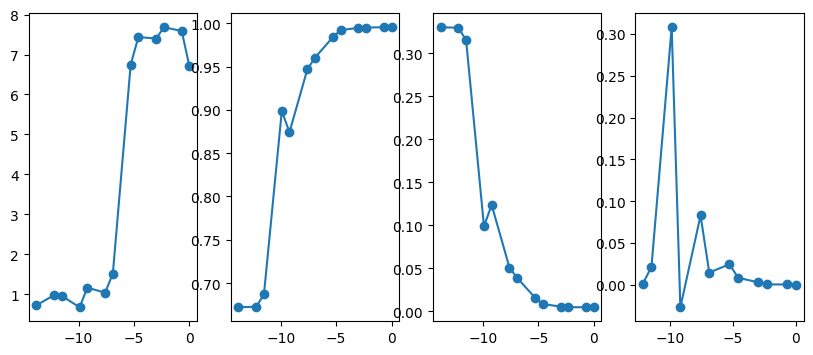

In [17]:
diff_morans_i = [(mi1 - mi0)/mi0 for mi1, mi0 in zip(morans_i[1:], morans_i[0:-1])]

fig, axs = plt.subplots(1, 4, figsize=(10, 4))

axs[0].plot(np.log(lambda_set), gaussian_spread, 'o-')
axs[1].plot(np.log(lambda_set), morans_i, 'o-')
axs[2].plot(np.log(lambda_set), gearys_c, 'o-')
axs[3].plot(np.log(lambda_set[1:]), diff_morans_i, 'o-')

In [18]:
# Choose the model with the optimum lamda
lam = lambda_set[4]
print(f"The selected lambda: {lam}")
X_GNN_lam = f"X_GNN_{lam}"
print(f"Embedding shape: {adata.obsm[X_GNN_lam].shape}")

The selected lambda: 0.0001
Embedding shape: (31413, 100)


In [19]:
X_new = adata.obsm[X_GNN_lam]
adata_new = sc.AnnData(X_new)
adata_new.obs = adata.obs

# Calculate distances in embedding space for clustering
sc.pp.neighbors(adata_new, use_rep='X')        # adata_new.obsp["connectivities"] is added
adata_new

AnnData object with n_obs × n_vars = 31413 × 100
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'x56', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes'
    uns: 'neighbors'
    obsp: 'distances', 'connectivities'

In [20]:
# Calculate distances in embedding space for clustering
# sc.pp.neighbors(adata, use_rep=X_GNN_lam)        # adata.obsp["spatial_connectivities"] is added
# Calculate UMAP for visualisation
# sc.tl.umap(adata)

In [21]:
# sc.tl.leiden(adata, resolution = .1)

In [22]:
# Clustering with leiden in the embedding space
# using diffrent resolutions

resolutions = np.arange(0.01, 1, 0.01)
resolutions = resolutions.round(4).tolist()
adata_new, Clusters = utils.multiple_lediden(adata_new, resolutions, key_added='leiden', n_jobs=20, verbos=True)

Resolution = 0.04 Started!
Resolution = 0.13 Started!
Resolution = 0.1 Started!
Resolution = 0.08 Started!
Resolution = 0.2 Started!
Resolution = 0.17 Started!
Resolution = 0.14 Started!
Resolution = 0.19 Started!
Resolution = 0.03 Started!
Resolution = 0.15 Started!
Resolution = 0.05 Started!
Resolution = 0.09 Started!
Resolution = 0.02 Started!
Resolution = 0.01 Started!Resolution = 0.06 Started!

Resolution = 0.16 Started!
Resolution = 0.07 Started!
Resolution = 0.12 Started!
Resolution = 0.18 Started!
Resolution = 0.11 Started!
Resolution = 0.04 Done!
Resolution = 0.21 Started!
Resolution = 0.02 Done!
Resolution = 0.22 Started!
Resolution = 0.08 Done!
Resolution = 0.23 Started!
Resolution = 0.06 Done!
Resolution = 0.24 Started!
Resolution = 0.01 Done!
Resolution = 0.25 Started!
Resolution = 0.07 Done!
Resolution = 0.26 Started!
Resolution = 0.17 Done!
Resolution = 0.27 Started!
Resolution = 0.03 Done!
Resolution = 0.28 Started!
Resolution = 0.15 Done!
Resolution = 0.29 Started!
Res

In [23]:
# Calculate clustering measures
N_clusters = []
Sil_score = []
DB_score = []
CH_score = []
MI_score = []

# for r in resolution:
for clusters in Clusters:
    # adata.obs[clusters.name] = clusters
    n_cluster, sil_score, db_score, ch_score, mi_score = utils.clustering_metrics(adata_new,
                                                                            obs_key = clusters.name,
                                                                            obsm_key = X_GNN_lam,
                                                                            obsp_key = "spatial_connectivities")
    N_clusters.append(n_cluster)
    Sil_score.append(sil_score)
    DB_score.append(db_score)
    MI_score.append(ch_score)
    CH_score.append(mi_score)

half of the window is: [1.00000005e+00 7.07106852e-01 3.16227766e-04]
(array([88]),)


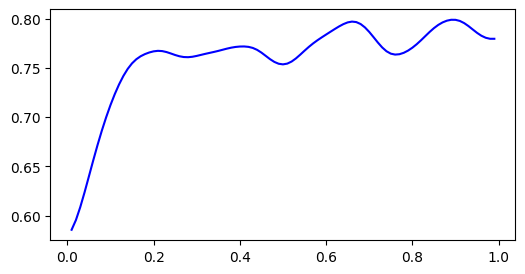

In [24]:
# Clustering robustness
ARI_avg = utils.windowed_ari(Clusters, window_len_half = 3)

# Plot ARI
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(resolutions, ARI_avg, color='blue')

find_peaks(ARI_avg)

In [25]:
# Calculate UMAP for visualisation
sc.tl.umap(adata_new)
# add spatial key for visualisation
adata_new.obsm["spatial"] = adata_new.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

0.15


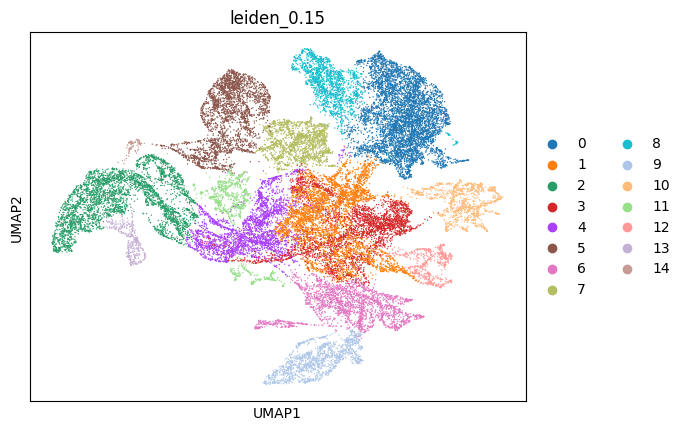

In [26]:
# resolution_best = resolutions[11]
resolution_best = 0.15
print(resolution_best)

sc.pl.umap(
    adata_new,
    color=[
        # "total_counts",
        #"n_genes_by_counts",
        "leiden_"+str(resolution_best),
        #"leiden"
    ],
    wspace=0.4,
)

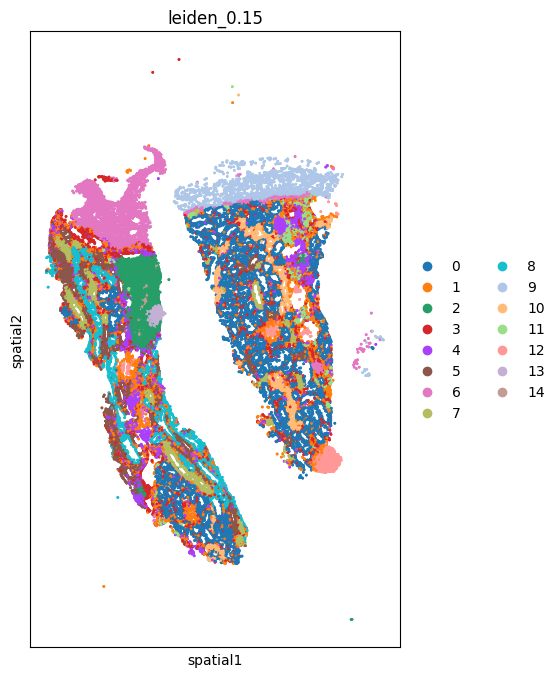

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

sq.pl.spatial_scatter(
    adata_new,
    library_id="spatial",
    shape=None,
    color=[
        "leiden_"+str(resolution_best),
        #"leiden"
    ],
    wspace=0.1,
    ax = ax
)


In [28]:
# Save adata
adata.X = X
adata.write(f"adata/Result_slide_{slide}_sample_{sample}.h5ad")
f"adata/Result_slide_{slide}_sample_{sample}.h5ad"

'adata/Result_slide_8_sample_x56.h5ad'